## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

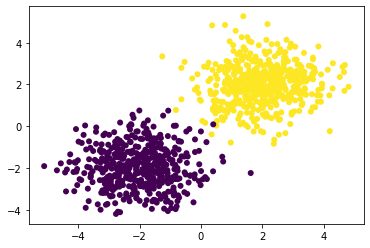

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 2
LogSoftMax

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

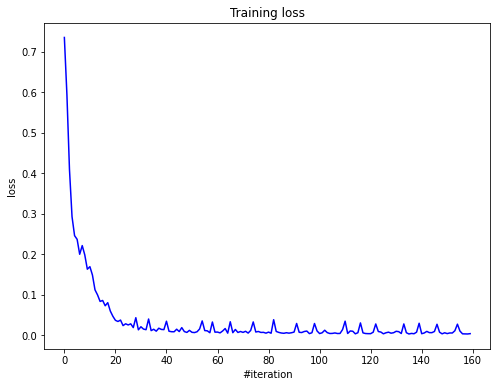

Current loss: 0.003752


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist

X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

In [10]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [11]:
def train(net, n_epoch, batch_size, X, Y, optimizer=sgd_momentum):
  loss_history = []
  for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
      net.zeroGradParameters()
      # Forward
      predictions = net.forward(x_batch)
      loss = criterion.forward(predictions, y_batch)
      # Backward
      dp = criterion.backward(predictions, y_batch)
      net.backward(x_batch, dp)
      # Update weights
      optimizer(net.getParameters(), 
                    net.getGradParameters(), 
                    optimizer_config,
                    optimizer_state) 
        
      loss_history.append(loss)
  return loss_history

In [12]:
def build_net(activation):
  net = Sequential()
  net.add(Linear(X_train.shape[1], 400))
  net.add(activation())
  net.add(Linear(400, y_train.shape[1]))
  net.add(LogSoftMax())
  return net

In [13]:
n_epoch = 10
batch_size = 4096
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

In [14]:
%%time
losses = []
for activation in [ReLU, LeakyReLU, ELU, SoftPlus]:
  net = build_net(activation)
  losses.append(train(net, n_epoch, batch_size, X_train, y_train))

CPU times: user 5min 22s, sys: 1min 4s, total: 6min 26s
Wall time: 3min 17s


In [15]:
def plot_losses(losses, labels, figsize=(18, 8)):
  display.clear_output(wait=True)
  plt.figure(figsize=figsize)
  for loss, label in zip(losses, labels):
    plt.plot(loss, label=label)
  plt.xlabel("#iteration")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

In [16]:
labels = ['ReLU', 'LeakyReLU', 'ELU', 'SoftPlus']

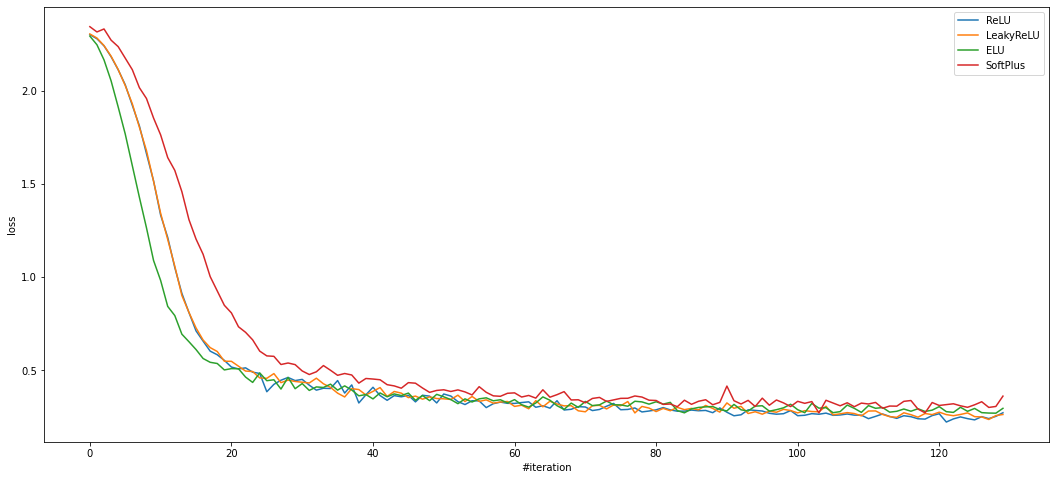

In [17]:
plot_losses(losses, labels)

In [18]:
def build_net_with_batch(activation):
  net = Sequential()
  net.add(Linear(X_train.shape[1], 400))
  net.add(BatchNormalization(0.9))
  net.add(ChannelwiseScaling(400))
  net.add(activation())
  net.add(Dropout(0.3))
  net.add(Linear(400, y_train.shape[1]))
  net.add(LogSoftMax())
  return net

In [19]:
n_epoch = 10
batch_size = 4096
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

In [20]:
%%time
losses_batch = []
for activation in [ReLU, LeakyReLU, ELU, SoftPlus]:
  net_batch = build_net_with_batch(activation)
  losses_batch.append(train(net_batch, n_epoch, batch_size, X_train, y_train))

CPU times: user 6min 32s, sys: 1min 49s, total: 8min 21s
Wall time: 4min 24s


In [21]:
labels_with_batch = labels + [label + ' BatchNormalization' for label in labels]

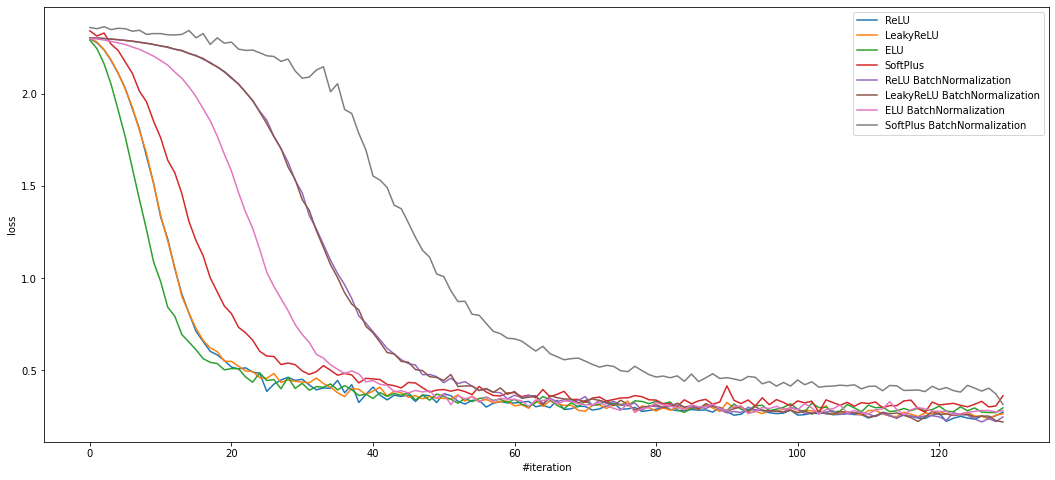

In [22]:
plot_losses(losses + losses_batch, labels_with_batch)

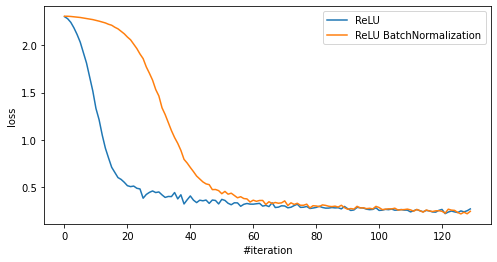

In [23]:
plot_losses([losses[0], losses_batch[0]], [labels_with_batch[0], labels_with_batch[4]], (8, 4))

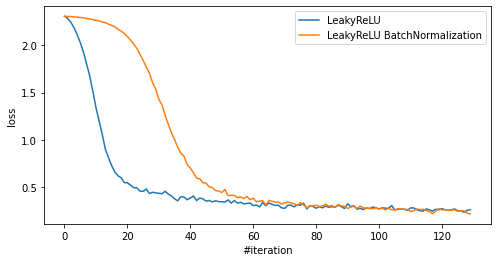

In [24]:
plot_losses([losses[1], losses_batch[1]], [labels_with_batch[1], labels_with_batch[5]], (8, 4))

In [25]:
optimizer_config = {'learning_rate': 3e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_state = {}

In [26]:
%%time
losses_adam = []
for activation in [ReLU, LeakyReLU, ELU, SoftPlus]:
  net = build_net(activation)
  losses_adam.append(train(net, n_epoch, batch_size, X_train, y_train, adam_optimizer))

CPU times: user 5min 25s, sys: 1min 9s, total: 6min 34s
Wall time: 3min 23s


In [27]:
labels_with_adam = labels + [label + ' adam' for label in labels]

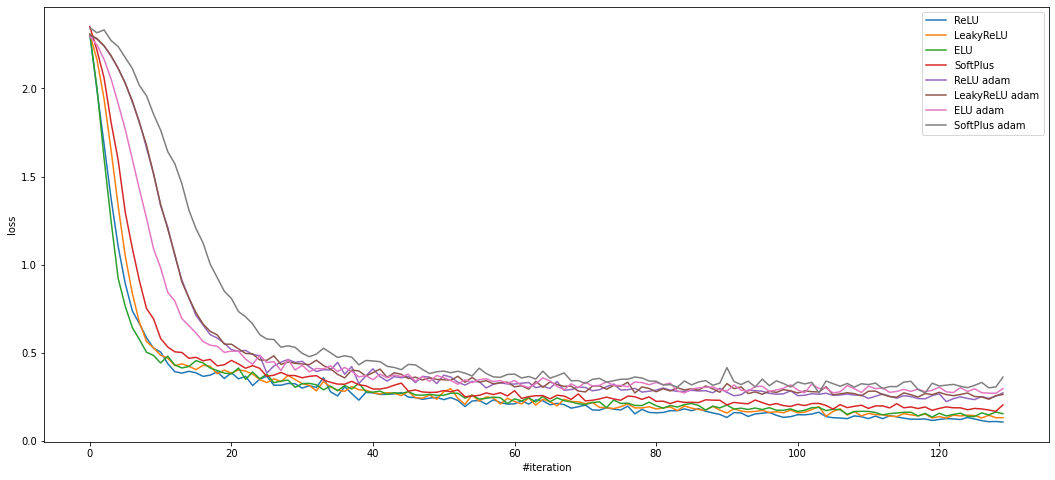

In [28]:
plot_losses(losses_adam + losses, labels_with_adam)

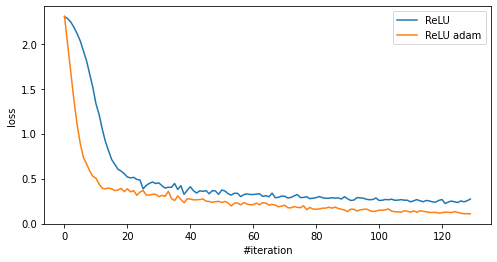

In [29]:
plot_losses([losses[0], losses_adam[0]], [labels_with_batch[0], labels_with_adam[4]], (8, 4))

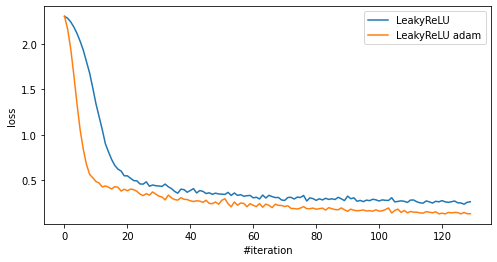

In [30]:
plot_losses([losses[1], losses_adam[1]], [labels_with_batch[1], labels_with_adam[5]], (8, 4))

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Батчинг работает медленее и на итерациях меньше 70 показывает результаты хуже.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [31]:
def my_build_net_with_batch(activation):
  net = Sequential()
  net.add(Linear(X_train.shape[1], 400))
  net.add(ChannelwiseScaling(400))
  net.add(activation())
  net.add(Linear(400, y_train.shape[1]))
  net.add(LogSoftMax())
  return net

Print here your accuracy on test set. It should be around 90%.

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
optimizer_config = {'learning_rate': 3e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_state = {}
n_epoch = 10
batch_size = 2048

In [34]:
%%time
net = my_build_net_with_batch(LeakyReLU)
my_losses = train(net, n_epoch, batch_size, X_train, y_train, adam_optimizer)
net.evaluate()
y = encoder.inverse_transform(net.forward(X_test)).reshape(-1)
y_test = encoder.inverse_transform(y_test).reshape(-1)
acc = accuracy_score(y_test, y)
print(f'LeakyReLU accuracy: {acc}')

LeakyReLU accuracy: 0.9595
CPU times: user 1min 16s, sys: 12.8 s, total: 1min 29s
Wall time: 45.6 s


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [35]:
import torch
from torch import nn

In [36]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [37]:
encoder = OneHotEncoder()

y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

In [38]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [39]:
def train_torch(model, n_epoch, batch_size, X, Y, losser, optimizer):
  loss_history = []
  for i in range(n_epoch):
    for x_batch, y_batch in get_batches((torch.FloatTensor(X_train), torch.Tensor(y_train)), batch_size):
        
        optimizer.zero_grad()
        
        predictions = model.forward(x_batch)
        loss = losser(predictions, torch.max(y_batch, 1)[1])
        loss.backward()
        loss = loss.item()
        optimizer.step()
        
        loss_history.append(loss)

  return loss_history

In [40]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 10),
    nn.LogSoftmax()
    )

In [41]:
losser = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
n_epoch = 10
batch_size = 2048

In [42]:
%%time
loss = train_torch(model, n_epoch, batch_size, X_train, y_train, losser, optimizer)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 21.1 s, sys: 186 ms, total: 21.3 s
Wall time: 21.2 s


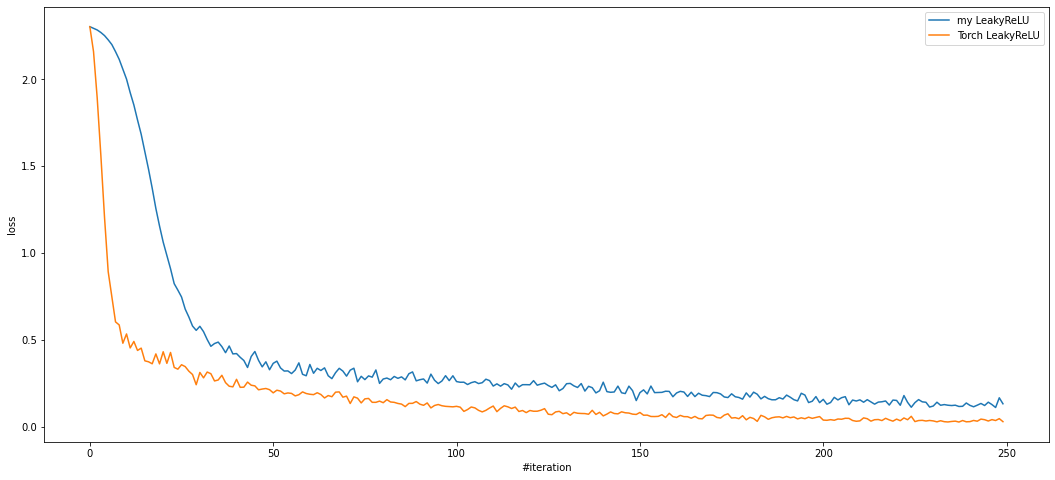

In [43]:
plot_losses([my_losses, loss], ["my LeakyReLU", "Torch LeakyReLU"])